In [2]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. SET YOUR LOCAL PATHS
# Assuming you are in the "Plant Disease Prediction" folder
base_dir = "New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = 224 # Or 300, matching your ann_train.py

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
import torch
from pathlib import Path

BATCH_SIZE = 32
IMG_SIZE = 300  # IMPORTANT: Changed from 224 to 299 for InceptionV3
EPOCHS = 10     # IMPORTANT: reduce from 20 → faster

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DATA_PATH = Path("/content/reduced_dataset")
TRAIN_PATH = DATA_PATH / "train"
VALID_PATH = DATA_PATH / "valid"


CHECKPOINT_PATH = "/content/best_model.pth"
LABELS_PATH = "/content/labels.txt"

print("Using device:", DEVICE)

Using device: cuda


In [ ]:
import os
import shutil
import random
from pathlib import Path

# Original dataset
SOURCE_PATH = Path("/content/New Plant Diseases Dataset(Augmented)")

# New reduced dataset
TARGET_PATH = Path("/content/reduced_dataset")
TRAIN_SRC = SOURCE_PATH / "train"
VALID_SRC = SOURCE_PATH / "valid"
TRAIN_DST = TARGET_PATH / "train"
VALID_DST = TARGET_PATH / "valid"

MAX_IMAGES = 150  # per class

def reduce_split(src, dst):
    for class_name in os.listdir(src):
        class_src = src / class_name
        class_dst = dst / class_name
        class_dst.mkdir(parents=True, exist_ok=True)

        images = os.listdir(class_src)
        random.shuffle(images)
        images = images[:MAX_IMAGES]

        for img in images:
            shutil.copy(class_src / img, class_dst / img)

# Create reduced dataset
print("Creating reduced dataset...")
reduce_split(TRAIN_SRC, TRAIN_DST)
reduce_split(VALID_SRC, VALID_DST)

print("✅ Reduced dataset created at:", TARGET_PATH)


In [7]:
!ls /content/reduced_dataset
!ls /content/reduced_dataset/train


train  valid
 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_v

In [8]:
# src/data_loader.py

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import updated values from config.py
# from src.config import TRAIN_PATH, VALID_PATH, IMG_SIZE, BATCH_SIZE


def create_dataloaders():

    # 1. Define Transformations (UNCHANGED LOGIC)
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # 2. Load Datasets (UNCHANGED)
    print("Loading Training Data...")
    train_dataset = datasets.ImageFolder(
        root=str(TRAIN_PATH),
        transform=train_transforms
    )

    print("Loading Validation Data...")
    val_dataset = datasets.ImageFolder(
        root=str(VALID_PATH),
        transform=val_transforms
    )

    # Class names
    class_names = train_dataset.classes
    print(f"✅ Detected {len(class_names)} classes")

    # 3. Create DataLoaders (UNCHANGED)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count(),
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    )

    return train_dataloader, val_dataloader, class_names

EfficientNet-B3 (Baseline)

In [9]:
import torch.nn as nn
from torchvision import models

class EfficientNetB3_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.efficientnet_b3(
            weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
        )

        # Freeze backbone
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_effnet_model(num_classes, device):
    model = EfficientNetB3_Model(num_classes)
    model.to(device)
    print("✅ EfficientNet-B3 initialized")
    return model


ResNet-50

In [10]:
import torch.nn as nn
from torchvision import models

class ResNet50_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V2
        )

        # Freeze backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features

        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_resnet_model(num_classes, device):
    model = ResNet50_Model(num_classes)
    model.to(device)
    print("✅ ResNet-50 initialized")
    return model


DenseNet-121

In [11]:
import torch.nn as nn
from torchvision import models

class DenseNet121_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1
        )

        # Freeze backbone
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        in_features = self.base_model.classifier.in_features

        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_densenet_model(num_classes, device):
    model = DenseNet121_Model(num_classes)
    model.to(device)
    print("✅ DenseNet-121 initialized")
    return model


MobileNet-V2

In [12]:
import torch.nn as nn
from torchvision import models

class MobileNetV2_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
        )

        # Freeze backbone
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_mobilenet_model(num_classes, device):
    model = MobileNetV2_Model(num_classes)
    model.to(device)
    print("✅ MobileNet-V2 initialized")
    return model


VGG15

In [13]:
# ================================
# MODEL 5: VGG16
# ================================

import torch
import torch.nn as nn
from torchvision import models

MODEL_NAME_VGG = "VGG16"

class VGG16Classifier(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Classifier, self).__init__()

        # Load pretrained VGG16
        self.base_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Freeze feature extractor
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        # Replace classifier
        in_features = self.base_model.classifier[6].in_features

        self.base_model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_vgg16(num_classes, device):
    model = VGG16Classifier(num_classes)
    model.to(device)
    print("✅ VGG16 model initialized")
    return model


InceptionV3

In [14]:
# ================================
# MODEL 6: INCEPTION V3
# ================================

import torch
import torch.nn as nn
from torchvision import models

MODEL_NAME_INCEPTION = "InceptionV3"

class InceptionV3Classifier(nn.Module):
    def __init__(self, num_classes):
        super(InceptionV3Classifier, self).__init__()

        # Load pretrained InceptionV3
        self.base_model = models.inception_v3(
            weights=models.Inception_V3_Weights.IMAGENET1K_V1
            # aux_logits=False is removed as it conflicts with pretrained weights
        )

        # Freeze feature extractor
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace final FC layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


def build_inception(num_classes, device):
    model = InceptionV3Classifier(num_classes)
    model.to(device)
    print("✅ InceptionV3 model initialized")
    return model

For each model block, we will:

Build the model

Train it

Validate it

Store:

Training loss per epoch

Validation loss per epoch

Training accuracy per epoch

Validation accuracy per epoch

Best validation accuracy

Training time

Final model weights

Nothing visual yet.

In [15]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        # 🔧 FIX FOR INCEPTION (DOES NOT AFFECT OTHER MODELS)
        if hasattr(outputs, "logits"):
            outputs = outputs.logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct.double() / total

    return epoch_loss, epoch_acc.item()


In [25]:
def validate_one_epoch(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # 🔧 SAME FIX HERE
            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * images.size(0)
            running_correct += torch.sum(preds == labels)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct.double() / total

    return epoch_loss, epoch_acc.item()


In [18]:
def train_model(model, train_loader, val_loader, device, epochs, lr=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "best_val_acc": 0.0,
        "training_time": 0.0
    }

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_acc > history["best_val_acc"]:
            history["best_val_acc"] = val_acc

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}\n"
            f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}"
        )

    history["training_time"] = time.time() - start_time
    return history


In [19]:
#training efficientnet-b3

train_dataloader, val_dataloader, class_names = create_dataloaders()
num_classes = len(class_names)

model_effnet = build_effnet_model(num_classes, DEVICE)

history_effnet = train_model(
    model_effnet,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)

Loading Training Data...
Loading Validation Data...
✅ Detected 38 classes
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 183MB/s]


✅ EfficientNet-B3 initialized

Epoch 1/10


Train Loss: 2.0787 | Train Acc: 0.5053
Val   Loss: 0.8687 | Val   Acc: 0.8312

Epoch 2/10


Train Loss: 0.8417 | Train Acc: 0.7668
Val   Loss: 0.5202 | Val   Acc: 0.8744

Epoch 3/10


Train Loss: 0.6120 | Train Acc: 0.8237
Val   Loss: 0.3899 | Val   Acc: 0.9004

Epoch 4/10


Train Loss: 0.5060 | Train Acc: 0.8447
Val   Loss: 0.3193 | Val   Acc: 0.9181

Epoch 5/10


Train Loss: 0.4797 | Train Acc: 0.8526
Val   Loss: 0.3011 | Val   Acc: 0.9181

Epoch 6/10


Train Loss: 0.4458 | Train Acc: 0.8586
Val   Loss: 0.2749 | Val   Acc: 0.9240

Epoch 7/10


Train Loss: 0.4018 | Train Acc: 0.8719
Val   Loss: 0.2663 | Val   Acc: 0.9226

Epoch 8/10


Train Loss: 0.3828 | Train Acc: 0.8805
Val   Loss: 0.2483 | Val   Acc: 0.9261

Epoch 9/10


Train Loss: 0.3643 | Train Acc: 0.8814
Val   Loss: 0.2353 | Val   Acc: 0.9275

Epoch 10/10


Train Loss: 0.3376 | Train Acc: 0.8979
Val   Loss: 0.2159 | Val   Acc: 0.9330


In [20]:
#resnet-50
model_resnet = build_resnet_model(num_classes, DEVICE)

history_resnet = train_model(
    model_resnet,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


✅ ResNet-50 initialized

Epoch 1/10


Train Loss: 2.3472 | Train Acc: 0.4375
Val   Loss: 1.1790 | Val   Acc: 0.7826

Epoch 2/10


Train Loss: 0.9323 | Train Acc: 0.7686
Val   Loss: 0.6101 | Val   Acc: 0.8691

Epoch 3/10


Train Loss: 0.6327 | Train Acc: 0.8281
Val   Loss: 0.4548 | Val   Acc: 0.8953

Epoch 4/10


Train Loss: 0.4791 | Train Acc: 0.8668
Val   Loss: 0.3340 | Val   Acc: 0.9219

Epoch 5/10


Train Loss: 0.3961 | Train Acc: 0.8937
Val   Loss: 0.2977 | Val   Acc: 0.9309

Epoch 6/10


Train Loss: 0.3448 | Train Acc: 0.8996
Val   Loss: 0.2304 | Val   Acc: 0.9396

Epoch 7/10


Train Loss: 0.3045 | Train Acc: 0.9072
Val   Loss: 0.2379 | Val   Acc: 0.9335

Epoch 8/10


Train Loss: 0.2858 | Train Acc: 0.9188
Val   Loss: 0.2243 | Val   Acc: 0.9395

Epoch 9/10


Train Loss: 0.2615 | Train Acc: 0.9226
Val   Loss: 0.2032 | Val   Acc: 0.9393

Epoch 10/10


Train Loss: 0.2391 | Train Acc: 0.9288
Val   Loss: 0.1854 | Val   Acc: 0.9495


In [21]:
#densenet-121
model_densenet = build_densenet_model(num_classes, DEVICE)

history_densenet = train_model(
    model_densenet,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 126MB/s]


✅ DenseNet-121 initialized

Epoch 1/10


Train Loss: 2.5080 | Train Acc: 0.3689
Val   Loss: 1.1713 | Val   Acc: 0.8144

Epoch 2/10


Train Loss: 1.1196 | Train Acc: 0.6946
Val   Loss: 0.7235 | Val   Acc: 0.8265

Epoch 3/10


Train Loss: 0.7577 | Train Acc: 0.7856
Val   Loss: 0.4378 | Val   Acc: 0.8956

Epoch 4/10


Train Loss: 0.6090 | Train Acc: 0.8221
Val   Loss: 0.3992 | Val   Acc: 0.8944

Epoch 5/10


Train Loss: 0.5416 | Train Acc: 0.8400
Val   Loss: 0.3506 | Val   Acc: 0.9035

Epoch 6/10


Train Loss: 0.5026 | Train Acc: 0.8454
Val   Loss: 0.3068 | Val   Acc: 0.9126

Epoch 7/10


Train Loss: 0.4591 | Train Acc: 0.8618
Val   Loss: 0.2934 | Val   Acc: 0.9154

Epoch 8/10


Train Loss: 0.4116 | Train Acc: 0.8719
Val   Loss: 0.2520 | Val   Acc: 0.9295

Epoch 9/10


Train Loss: 0.3899 | Train Acc: 0.8779
Val   Loss: 0.2605 | Val   Acc: 0.9247

Epoch 10/10


Train Loss: 0.3576 | Train Acc: 0.8907
Val   Loss: 0.2388 | Val   Acc: 0.9295


In [22]:
#mobilenet-v2
model_mobilenet = build_mobilenet_model(num_classes, DEVICE)

history_mobilenet = train_model(
    model_mobilenet,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 113MB/s]


✅ MobileNet-V2 initialized

Epoch 1/10


Train Loss: 2.4781 | Train Acc: 0.3572
Val   Loss: 1.2213 | Val   Acc: 0.7635

Epoch 2/10


Train Loss: 1.2393 | Train Acc: 0.6528
Val   Loss: 0.7134 | Val   Acc: 0.8428

Epoch 3/10


Train Loss: 0.9258 | Train Acc: 0.7226
Val   Loss: 0.5346 | Val   Acc: 0.8686

Epoch 4/10


Train Loss: 0.7920 | Train Acc: 0.7589
Val   Loss: 0.4884 | Val   Acc: 0.8691

Epoch 5/10


Train Loss: 0.7308 | Train Acc: 0.7737
Val   Loss: 0.4188 | Val   Acc: 0.8918

Epoch 6/10


Train Loss: 0.6969 | Train Acc: 0.7832
Val   Loss: 0.4181 | Val   Acc: 0.8823

Epoch 7/10


Train Loss: 0.6639 | Train Acc: 0.7953
Val   Loss: 0.3841 | Val   Acc: 0.8900

Epoch 8/10


Train Loss: 0.6350 | Train Acc: 0.8044
Val   Loss: 0.3235 | Val   Acc: 0.9137

Epoch 9/10


Train Loss: 0.5823 | Train Acc: 0.8161
Val   Loss: 0.3294 | Val   Acc: 0.9033

Epoch 10/10


Train Loss: 0.5743 | Train Acc: 0.8202
Val   Loss: 0.3060 | Val   Acc: 0.9128


In [26]:
# ================================
# InceptionV3
# ================================

model_inception = build_inception(num_classes, DEVICE)

history_inception = train_model(
    model_inception,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)

✅ InceptionV3 model initialized

Epoch 1/10
Train Loss: 2.7573 | Train Acc: 0.2860
Val   Loss: 1.7233 | Val   Acc: 0.6800

Epoch 2/10
Train Loss: 1.5460 | Train Acc: 0.5696
Val   Loss: 1.1613 | Val   Acc: 0.7414

Epoch 3/10
Train Loss: 1.2077 | Train Acc: 0.6419
Val   Loss: 0.8509 | Val   Acc: 0.7893

Epoch 4/10
Train Loss: 1.0511 | Train Acc: 0.6881
Val   Loss: 0.7700 | Val   Acc: 0.8037

Epoch 5/10
Train Loss: 0.9667 | Train Acc: 0.7107
Val   Loss: 0.7686 | Val   Acc: 0.7930

Epoch 6/10
Train Loss: 0.9141 | Train Acc: 0.7282
Val   Loss: 0.6907 | Val   Acc: 0.8068

Epoch 7/10
Train Loss: 0.8644 | Train Acc: 0.7316
Val   Loss: 0.6252 | Val   Acc: 0.8318

Epoch 8/10
Train Loss: 0.8419 | Train Acc: 0.7367
Val   Loss: 0.6337 | Val   Acc: 0.8207

Epoch 9/10
Train Loss: 0.8421 | Train Acc: 0.7370
Val   Loss: 0.5993 | Val   Acc: 0.8275

Epoch 10/10
Train Loss: 0.8029 | Train Acc: 0.7495
Val   Loss: 0.5582 | Val   Acc: 0.8433


In [28]:
model_vgg = build_vgg16(num_classes, DEVICE)

history_vgg = train_model(
    model_vgg,
    train_dataloader,
    val_dataloader,
    DEVICE,
    EPOCHS
)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 60.8MB/s]


✅ VGG16 model initialized

Epoch 1/10
Train Loss: 2.9236 | Train Acc: 0.1895
Val   Loss: 1.6397 | Val   Acc: 0.4809

Epoch 2/10
Train Loss: 1.6844 | Train Acc: 0.4702
Val   Loss: 0.9600 | Val   Acc: 0.7047

Epoch 3/10
Train Loss: 1.3650 | Train Acc: 0.5932
Val   Loss: 0.8159 | Val   Acc: 0.7551

Epoch 4/10
Train Loss: 1.1813 | Train Acc: 0.6551
Val   Loss: 0.5952 | Val   Acc: 0.8140

Epoch 5/10
Train Loss: 1.0771 | Train Acc: 0.6840
Val   Loss: 0.5981 | Val   Acc: 0.8261

Epoch 6/10
Train Loss: 1.0525 | Train Acc: 0.7026
Val   Loss: 0.6039 | Val   Acc: 0.8281

Epoch 7/10
Train Loss: 1.0067 | Train Acc: 0.7175
Val   Loss: 0.5488 | Val   Acc: 0.8400

Epoch 8/10
Train Loss: 0.9684 | Train Acc: 0.7226
Val   Loss: 0.5277 | Val   Acc: 0.8525

Epoch 9/10
Train Loss: 0.9092 | Train Acc: 0.7465
Val   Loss: 0.5398 | Val   Acc: 0.8456

Epoch 10/10
Train Loss: 0.8867 | Train Acc: 0.7570
Val   Loss: 0.4811 | Val   Acc: 0.8602


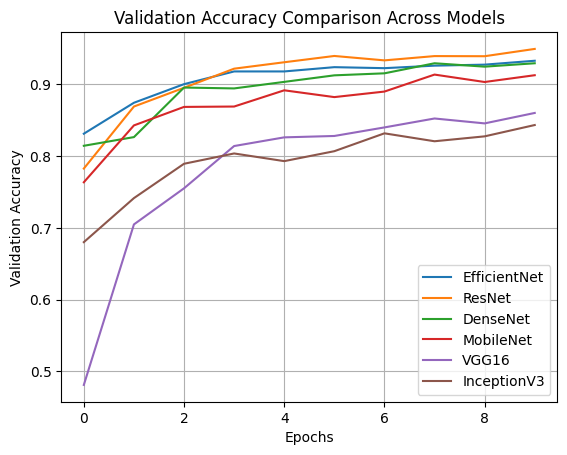

In [30]:
#comparison and visualizations
#validation accuracy vs epochs
import matplotlib.pyplot as plt

plt.figure()

plt.plot(history_effnet["val_acc"], label="EfficientNet")
plt.plot(history_resnet["val_acc"], label="ResNet")
plt.plot(history_densenet["val_acc"], label="DenseNet")
plt.plot(history_mobilenet["val_acc"], label="MobileNet")
plt.plot(history_vgg["val_acc"], label="VGG16")
plt.plot(history_inception["val_acc"], label="InceptionV3")  # or your 6th model

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison Across Models")
plt.legend()
plt.grid(True)
plt.show()

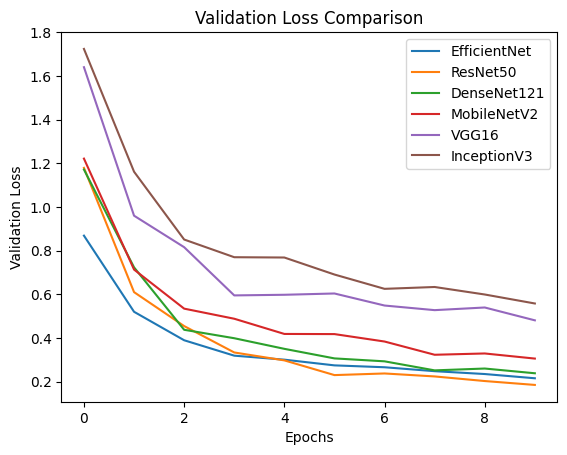

In [32]:
#loss vs epochs
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history_effnet["val_loss"], label="EfficientNet")
plt.plot(history_resnet["val_loss"], label="ResNet50")
plt.plot(history_densenet["val_loss"], label="DenseNet121")
plt.plot(history_mobilenet["val_loss"], label="MobileNetV2")
plt.plot(history_vgg["val_loss"], label="VGG16")
plt.plot(history_inception["val_loss"], label="InceptionV3")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


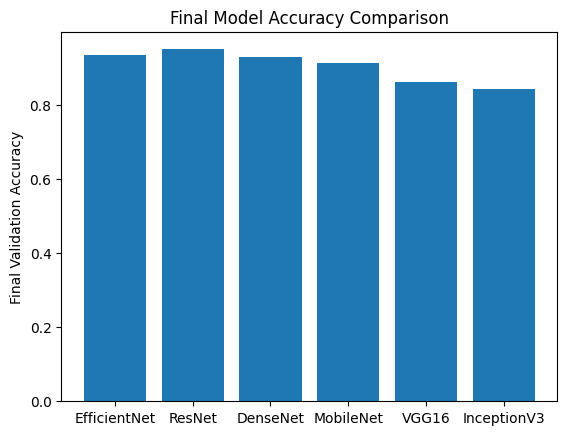

In [33]:
# Final validation accuracy using bar chart
models = [
    "EfficientNet",
    "ResNet",
    "DenseNet",
    "MobileNet",
    "VGG16",
    "InceptionV3"
]

final_acc = [
    history_effnet["val_acc"][-1],
    history_resnet["val_acc"][-1],
    history_densenet["val_acc"][-1],
    history_mobilenet["val_acc"][-1],
    history_vgg["val_acc"][-1],
    history_inception["val_acc"][-1]
]

plt.figure()
plt.bar(models, final_acc)
plt.ylabel("Final Validation Accuracy")
plt.title("Final Model Accuracy Comparison")
plt.show()


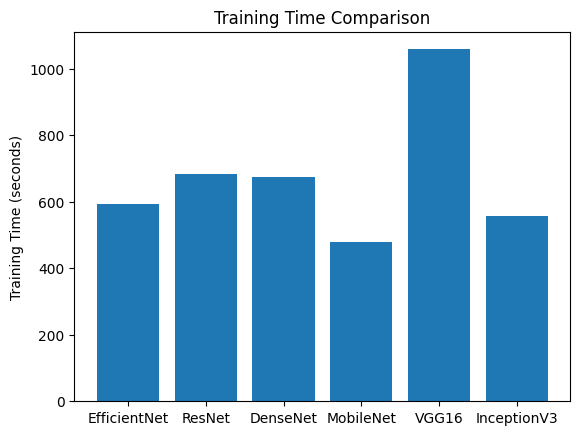

In [34]:
#time comparison
training_time = [
    history_effnet["training_time"],
    history_resnet["training_time"],
    history_densenet["training_time"],
    history_mobilenet["training_time"],
    history_vgg["training_time"],
    history_inception["training_time"]
]

plt.figure()
plt.bar(models, training_time)
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()


In [ ]:

#EfficientNet achieved the highest validation accuracy while maintaining reasonable training time.
#DenseNet showed stable learning but required longer training.
#MobileNet trained fastest but produced slightly lower accuracy, making it suitable for lightweight deployment

### more comparison methods

In [35]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time

def evaluate_model(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_time = time.time() - start_time

    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )

    acc = np.mean(np.array(all_preds) == np.array(all_labels))

    cm = confusion_matrix(all_labels, all_preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "time": total_time
    }


In [38]:
# evaluation of all 6 models
results = {}

results["EfficientNet"] = evaluate_model(model_effnet, val_dataloader, DEVICE)
results["ResNet"]       = evaluate_model(model_resnet, val_dataloader, DEVICE)
results["DenseNet"]     = evaluate_model(model_densenet, val_dataloader, DEVICE)
results["MobileNet"]    = evaluate_model(model_mobilenet, val_dataloader, DEVICE)

# new models
results["InceptionV3"]  = evaluate_model(model_inception, val_dataloader, DEVICE)
results["VGG16"]        = evaluate_model(model_vgg, val_dataloader, DEVICE)


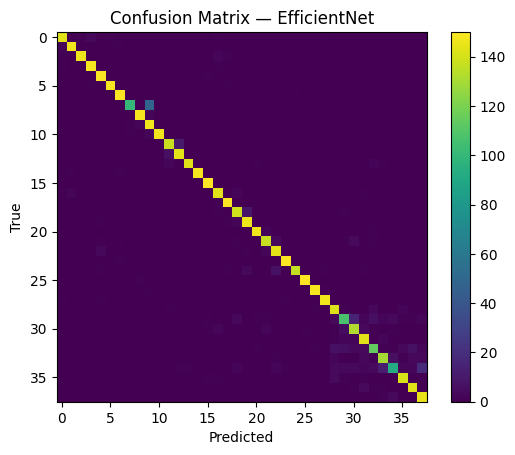

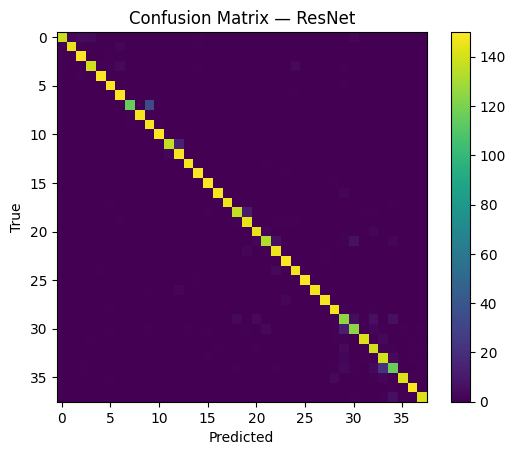

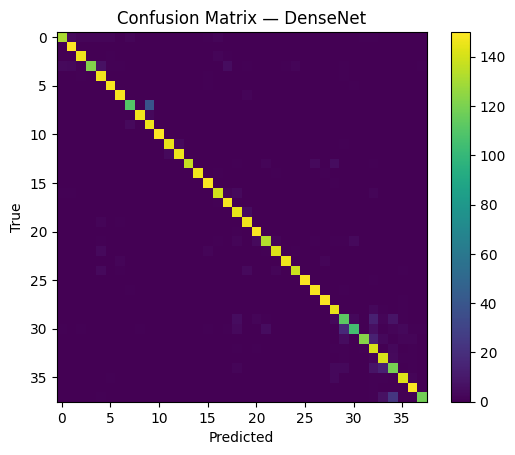

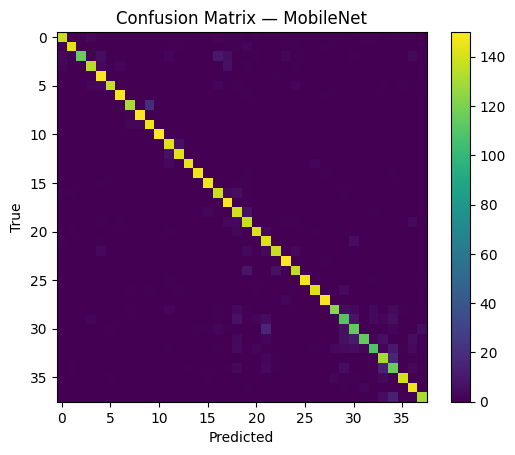

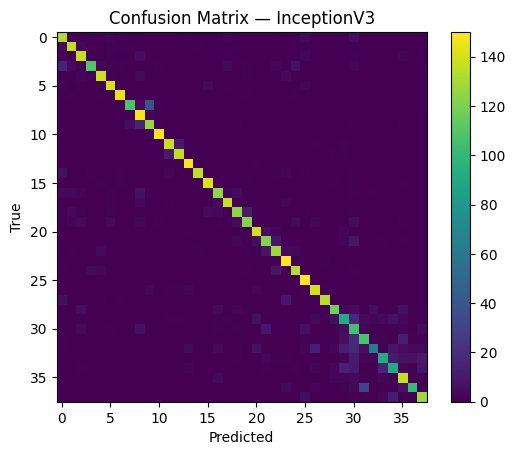

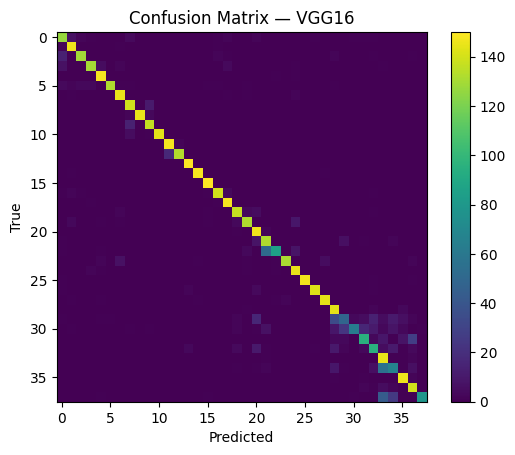

In [39]:
#confusion matrix comparison
import matplotlib.pyplot as plt

for model_name, data in results.items():
    plt.figure()
    plt.imshow(data["confusion_matrix"])
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()


In [40]:
import pandas as pd

metrics_table = []

for model_name, data in results.items():
    metrics_table.append([
        model_name,
        data["accuracy"],
        data["precision"],
        data["recall"],
        data["f1"]
    ])

df_metrics = pd.DataFrame(
    metrics_table,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

df_metrics


,Model,Accuracy,Precision,Recall,F1-Score
0,EfficientNet,0.932982,0.935111,0.932982,0.931671
1,ResNet,0.949474,0.951444,0.949474,0.949343
2,DenseNet,0.929474,0.934113,0.929474,0.929130
3,MobileNet,0.912807,0.916693,0.912807,0.912741
4,InceptionV3,0.843333,0.850580,0.843333,0.841478
5,VGG16,0.860175,0.872180,0.860175,0.855133


In [41]:
#final table
final_table = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [results[m]["accuracy"] for m in results],
    "Precision": [results[m]["precision"] for m in results],
    "Recall": [results[m]["recall"] for m in results],
    "F1-Score": [results[m]["f1"] for m in results],
    "Inference Time (s)": [results[m]["time"] for m in results]
})

final_table


,Model,Accuracy,Precision,Recall,F1-Score,Inference Time (s)
0,EfficientNet,0.932982,0.935111,0.932982,0.931671,27.756997
1,ResNet,0.949474,0.951444,0.949474,0.949343,31.855717
2,DenseNet,0.929474,0.934113,0.929474,0.929130,31.541781
3,MobileNet,0.912807,0.916693,0.912807,0.912741,22.212174
4,InceptionV3,0.843333,0.850580,0.843333,0.841478,25.944148
5,VGG16,0.860175,0.872180,0.860175,0.855133,49.812541
